In [1]:
# path to user functions
import sys  
sys.path.append('../Src/')

from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib 
# user functions
import UserMetricsFunctions as umf

# set seaborn theme
sns.set_theme()

# initializing variables
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


### Import Dataset

In [2]:
# import data
X = pd.read_pickle("../Data/X_dependent.pkl")
y = pd.read_pickle("../Data/y_label.pkl")

In [3]:
X.shape, y.shape

((9835, 249), (9835,))

### Split Dataset

In [4]:
from sklearn.model_selection import train_test_split

# mapping values
y = y.map({'Living': True, 'Dead': False})

# split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [5]:
from sklearn.preprocessing import MinMaxScaler

# initialize MinMaxScaler
scale = MinMaxScaler(feature_range=(1, 10))

# fit
fitScale = scale.fit(X_train)

# transform
X_train_scale = fitScale.transform(X_train)
X_test_scale = fitScale.transform(X_test)

### Select K Best

In [6]:
# import lfeature selection ibrary & functions
from sklearn.feature_selection import SelectKBest, f_classif, chi2, VarianceThreshold, mutual_info_classif

def selectKClassif(Xdata, ydata, K='all', function='f_classif'):
    """
    This function selects the most relevant features for classification tasks using statistical tests provided 
    by SelectKBest and removes constant features from the dataset. It also returns detailed information on the 
    chosen features, including their scores and p-values.
    """
    # remove constant features
    constanFilter = VarianceThreshold(threshold=0)  # removes features with zero variance
    X_data = constanFilter.fit_transform(Xdata)

    # update feature names after removing constant features
    remaining_feature_names = Xdata.columns[constanFilter.get_support(indices=True)]
    
    # Step 3: Apply SelectKBest with F-classif
    selector = SelectKBest(score_func=eval(function), k=K)
    X_new = selector.fit_transform(X_data, ydata)

    # update feature names to reflect remaining, selected features
    selected_List = [remaining_feature_names[i] for i in selector.get_support(indices=True)]
    
    # create a DataFrame with selected features and their F-scores
    feature_scores = selector.scores_

    # access the p-values
    p_values = selector.pvalues_

    # create DataFrame
    feature_scores_df = pd.DataFrame({
        'Feature': remaining_feature_names,
        'Score': feature_scores,
        'p_value': p_values
    }).sort_values(by='Score', ascending=False)

    # get ONLY selected Features
    DF_selected = feature_scores_df[feature_scores_df.Feature.isin(selected_List)]
    
    # retrun
    return DF_selected

### RandomForestClassifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
# function from sklearn.utils.class_weight computes the weights for each class to handle imbalanced datasets
from sklearn.utils.class_weight import compute_class_weight

# the 'balanced' mode adjusts weights inversely proportional to class frequencies in the input data for Random Forest
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# grid search Hyperparameters Random Forest Classfiier
parameters = {
    'n_estimators': [100, 300, 500],
    'min_samples_split': [30, 40, 50],
    'min_samples_leaf': [8, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7]
}


# Initialize Model with class weights
rfc_param = {'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}

# instantiate Random Forest Classifier
model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning
rfc_fit = umf.stratified_grid(model, parameters, X_train_scale, y_train, seed=RANDOM_STATE, nJobs=-1, nSplit=5, score = 'accuracy')

# best model
model = rfc_fit.best_estimator_

CV accuracy: 0.766 +/- 0.008


In [8]:
print(model)

RandomForestClassifier(class_weight={False: 1.109732016925247,
                                     True: 0.9100161924589405},
                       max_depth=7, min_samples_leaf=15, min_samples_split=50,
                       n_estimators=300, random_state=1776)


#### Feature Importance Plot

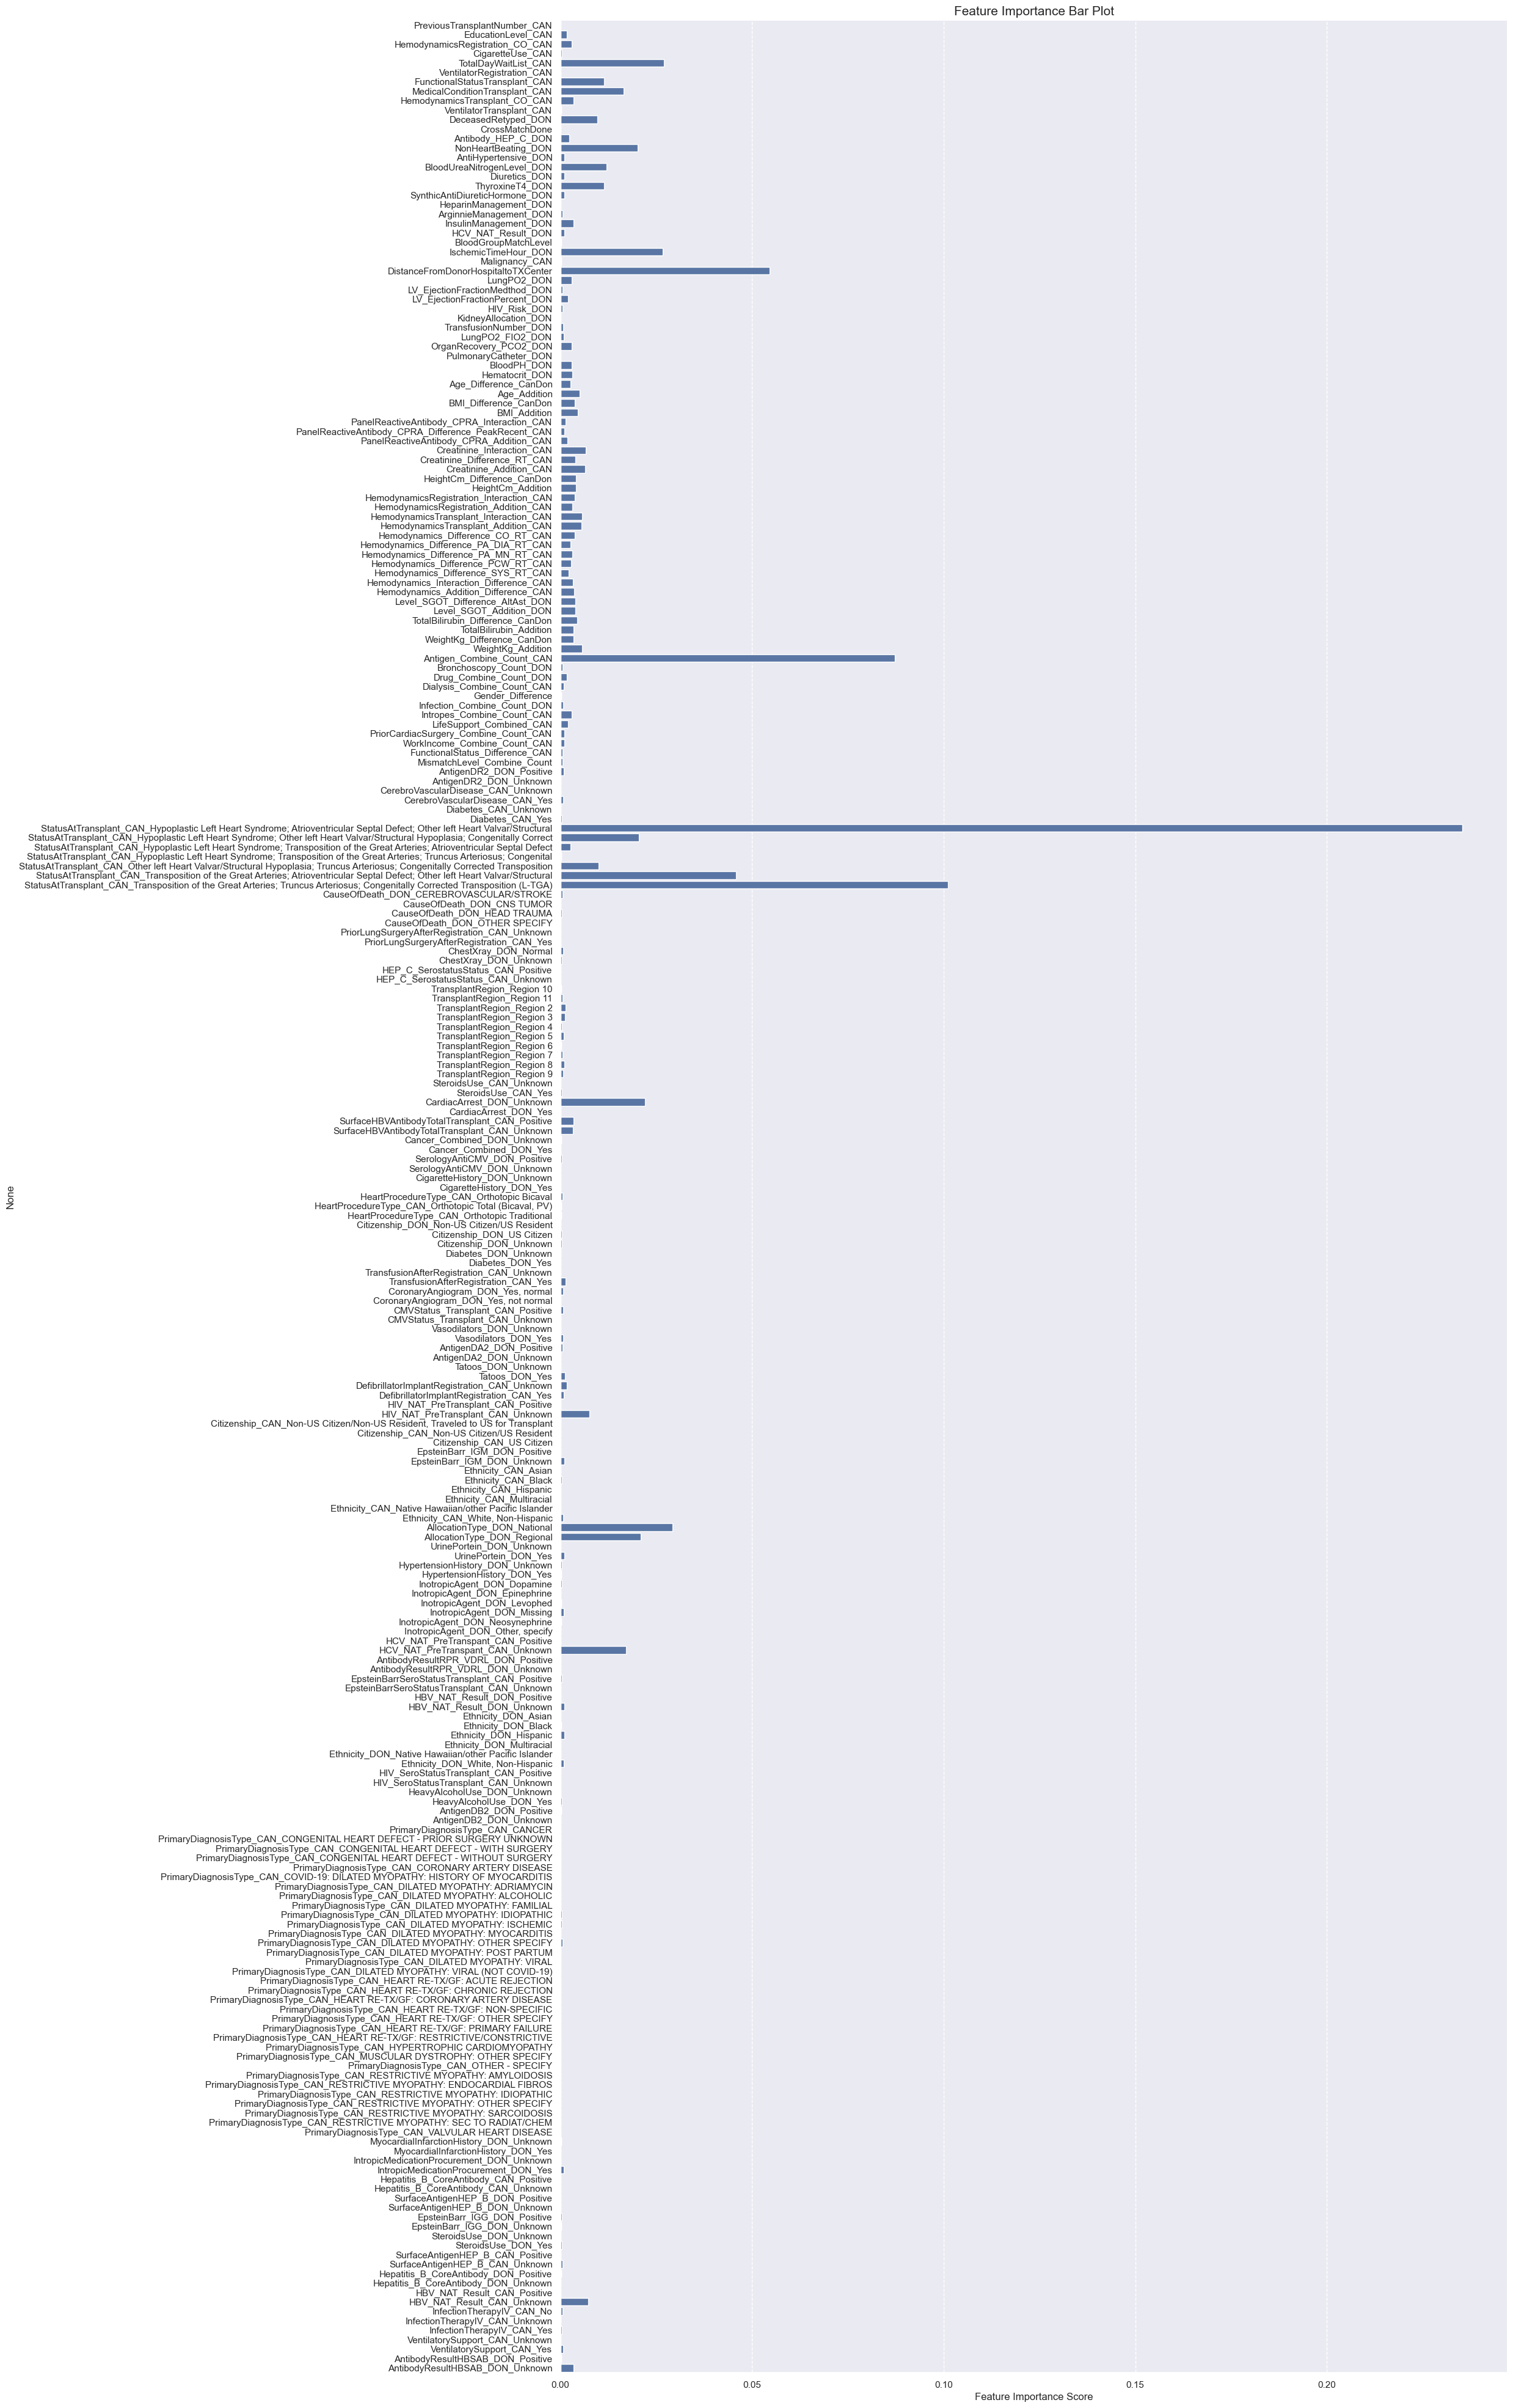

In [9]:
df_rfc = umf.plotFeatureImportance(model, pd.DataFrame(X_train_scale, columns=X_train.columns.to_list()),figsize=(20,50))

In [10]:
df_rfc.sort_values(by='Feature Importance Score', ascending=False).head(20)

,Feature Importance Score
StatusAtTransplant_CAN_Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,0.235304
StatusAtTransplant_CAN_Transposition of the Great Arteries; Truncus Arteriosus; Congenitally Corrected Transposition (L-TGA),0.101134
Antigen_Combine_Count_CAN,0.087250
DistanceFromDonorHospitaltoTXCenter,0.054518
StatusAtTransplant_CAN_Transposition of the Great Arteries; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,0.045736
AllocationType_DON_National,0.029197
TotalDayWaitList_CAN,0.027032
IschemicTimeHour_DON,0.026713
CardiacArrest_DON_Unknown,0.021978
AllocationType_DON_Regional,0.020947


#### Metrics

***** Classification Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.86      0.78      3545
        True       0.86      0.72      0.79      4323

    accuracy                           0.78      7868
   macro avg       0.79      0.79      0.78      7868
weighted avg       0.80      0.78      0.78      7868



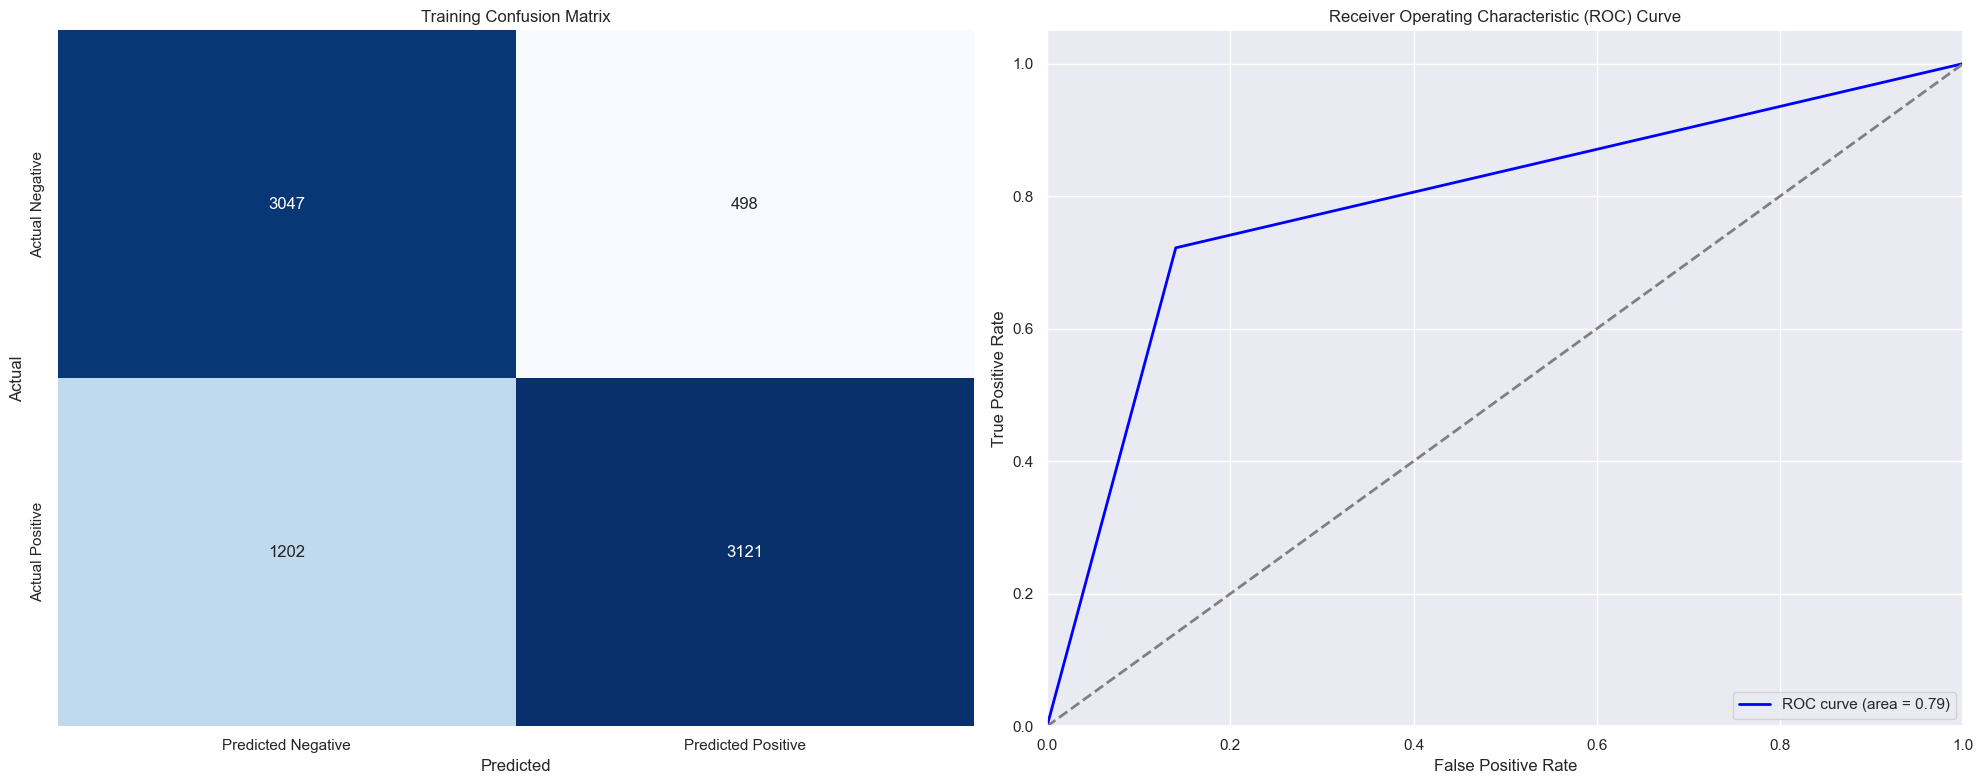

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Training,0.783935,0.721952,0.785948,0.775377,0.862393,0.85952,0.790736


In [11]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - All Features'
Model = 'rfc_fit'
Type = 'Training'

# display
df_classfication = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_train_scale, y_train, Type, metricDF=None)
df_classfication

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

       False       0.69      0.84      0.76       886
        True       0.84      0.69      0.76      1081

    accuracy                           0.76      1967
   macro avg       0.77      0.77      0.76      1967
weighted avg       0.77      0.76      0.76      1967



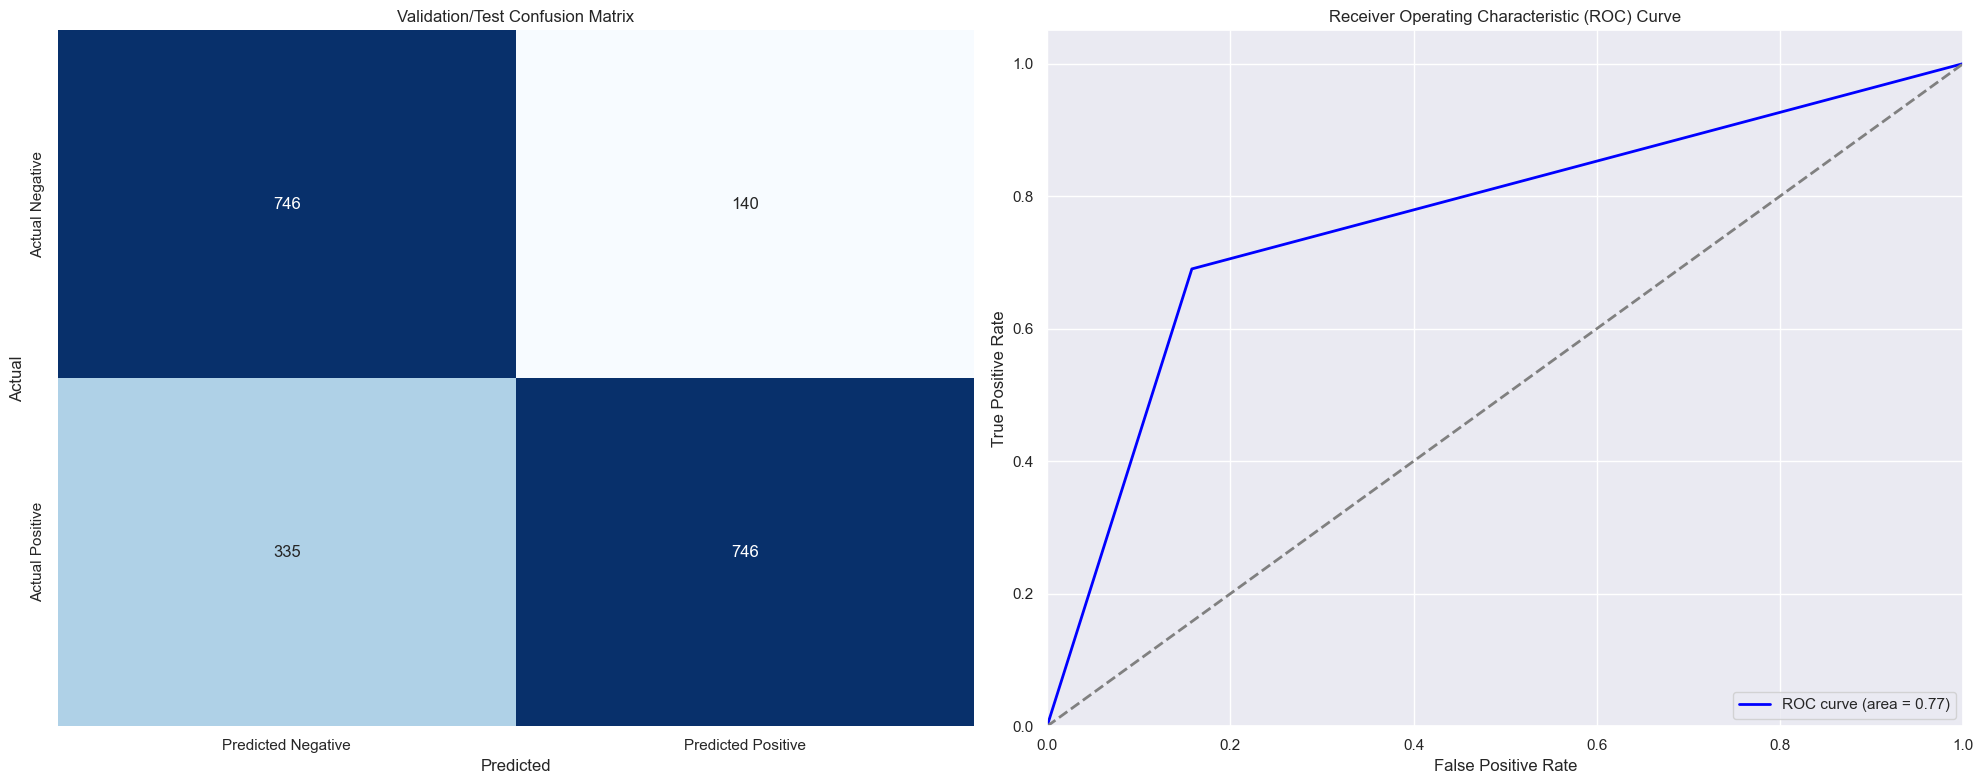

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Training,0.783935,0.721952,0.785948,0.775377,0.862393,0.859520,0.790736
1,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Validation/test,0.758516,0.690102,0.758516,0.751366,0.841986,0.841986,0.766044


In [12]:
# initialize variable
Type = 'Validation/Test'

# display
df_classfication = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_test_scale, y_test, Type, df_classfication)
df_classfication

### LogisticRegression

In [13]:
# import library
from sklearn.linear_model import LogisticRegression

# define the hyperparameter grid to search
parameters = dict(
C = list(np.round(np.linspace(0.01, 5, 20),2))
)

# Base Model
lrc_param = {'max_iter':10000, 'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}

# instantiate LogisticRegression Classifier
model = LogisticRegression(**lrc_param)

# CV with grid search for Hyper-Parameter tuning
lrc_fit = umf.stratified_grid(model, parameters, X_train_scale, y_train, seed=RANDOM_STATE, nJobs=-1, nSplit=5, score='accuracy')

# best model
model = lrc_fit.best_estimator_

CV accuracy: 0.770 +/- 0.009


In [14]:
print(model)

LogisticRegression(C=1.32,
                   class_weight={False: 1.109732016925247,
                                 True: 0.9100161924589405},
                   max_iter=10000, random_state=1776)


In [15]:
# # feature importance & plot
# lrc_df = umf.LogisticFeatureImportance(model, figsize=(30,30), fontsize=8)

#### Metrics

***** Classification Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.86      0.78      3545
        True       0.86      0.72      0.79      4323

    accuracy                           0.78      7868
   macro avg       0.79      0.79      0.78      7868
weighted avg       0.80      0.78      0.78      7868



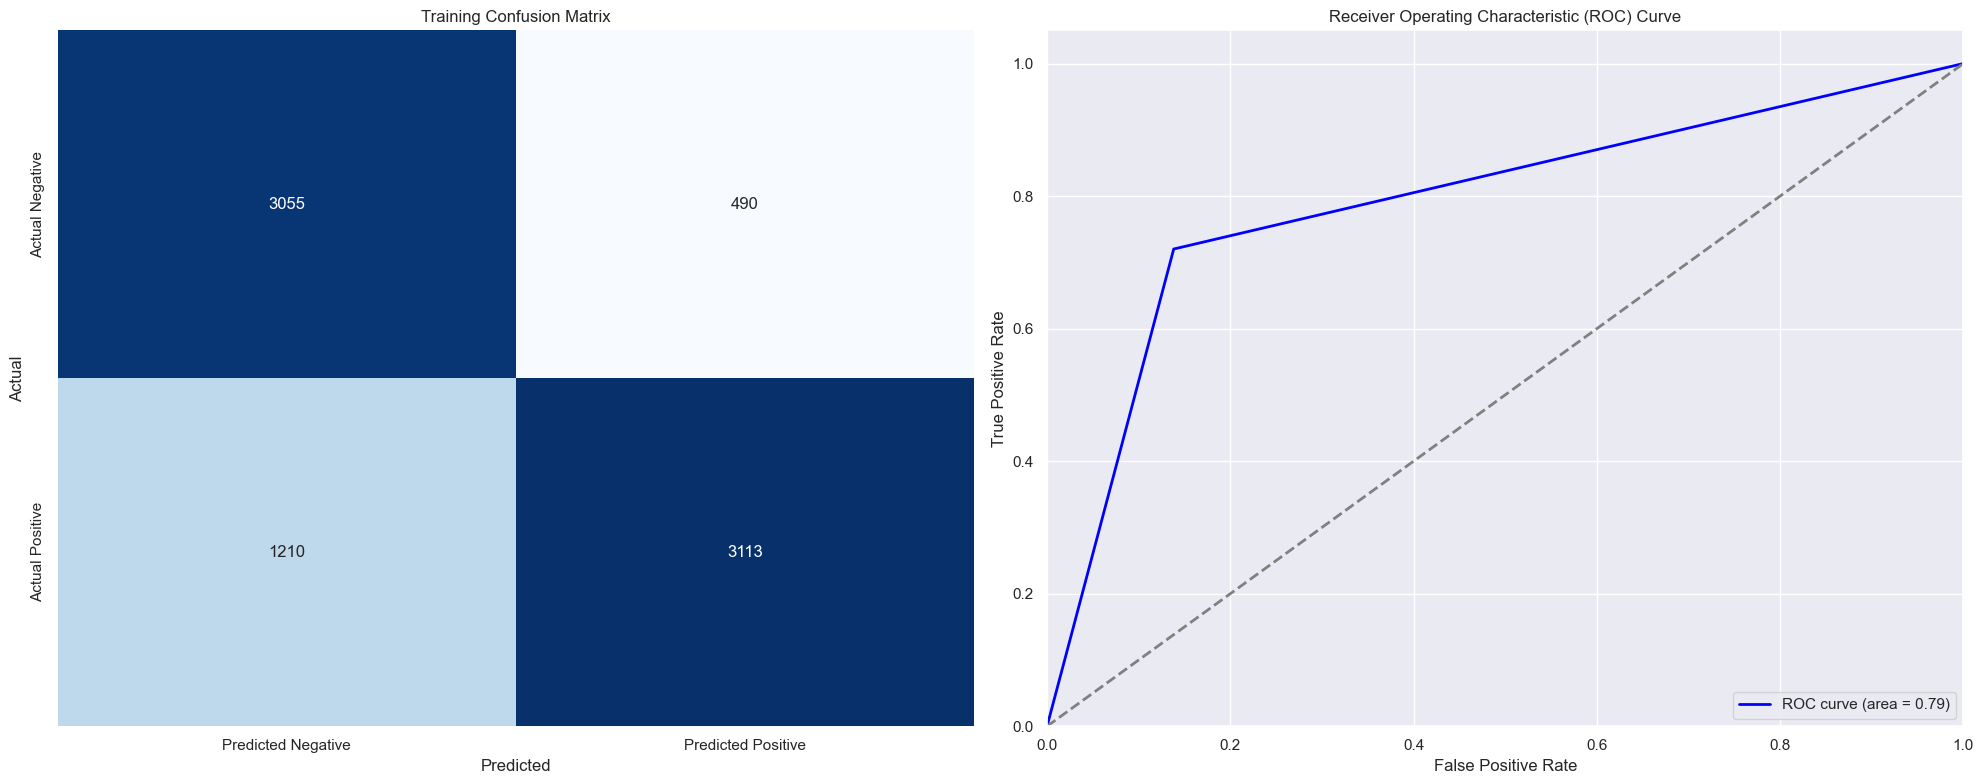

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Training,0.783935,0.721952,0.785948,0.775377,0.862393,0.859520,0.790736
1,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Validation/test,0.758516,0.690102,0.758516,0.751366,0.841986,0.841986,0.766044
2,LogisticRegression,lrc_fit,LogisticRegression - Grid Search - All Features,Training,0.783935,0.720102,0.785516,0.775957,0.864002,0.861777,0.790939


In [16]:
# initialize variables
Algorithm = 'LogisticRegression'
Desc = 'LogisticRegression - Grid Search - All Features'
Model = 'lrc_fit'
Type = 'Training'

# display
df_classfication = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_train_scale, y_train, Type, metricDF=df_classfication)
df_classfication

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

       False       0.69      0.85      0.76       886
        True       0.85      0.69      0.76      1081

    accuracy                           0.76      1967
   macro avg       0.77      0.77      0.76      1967
weighted avg       0.78      0.76      0.76      1967



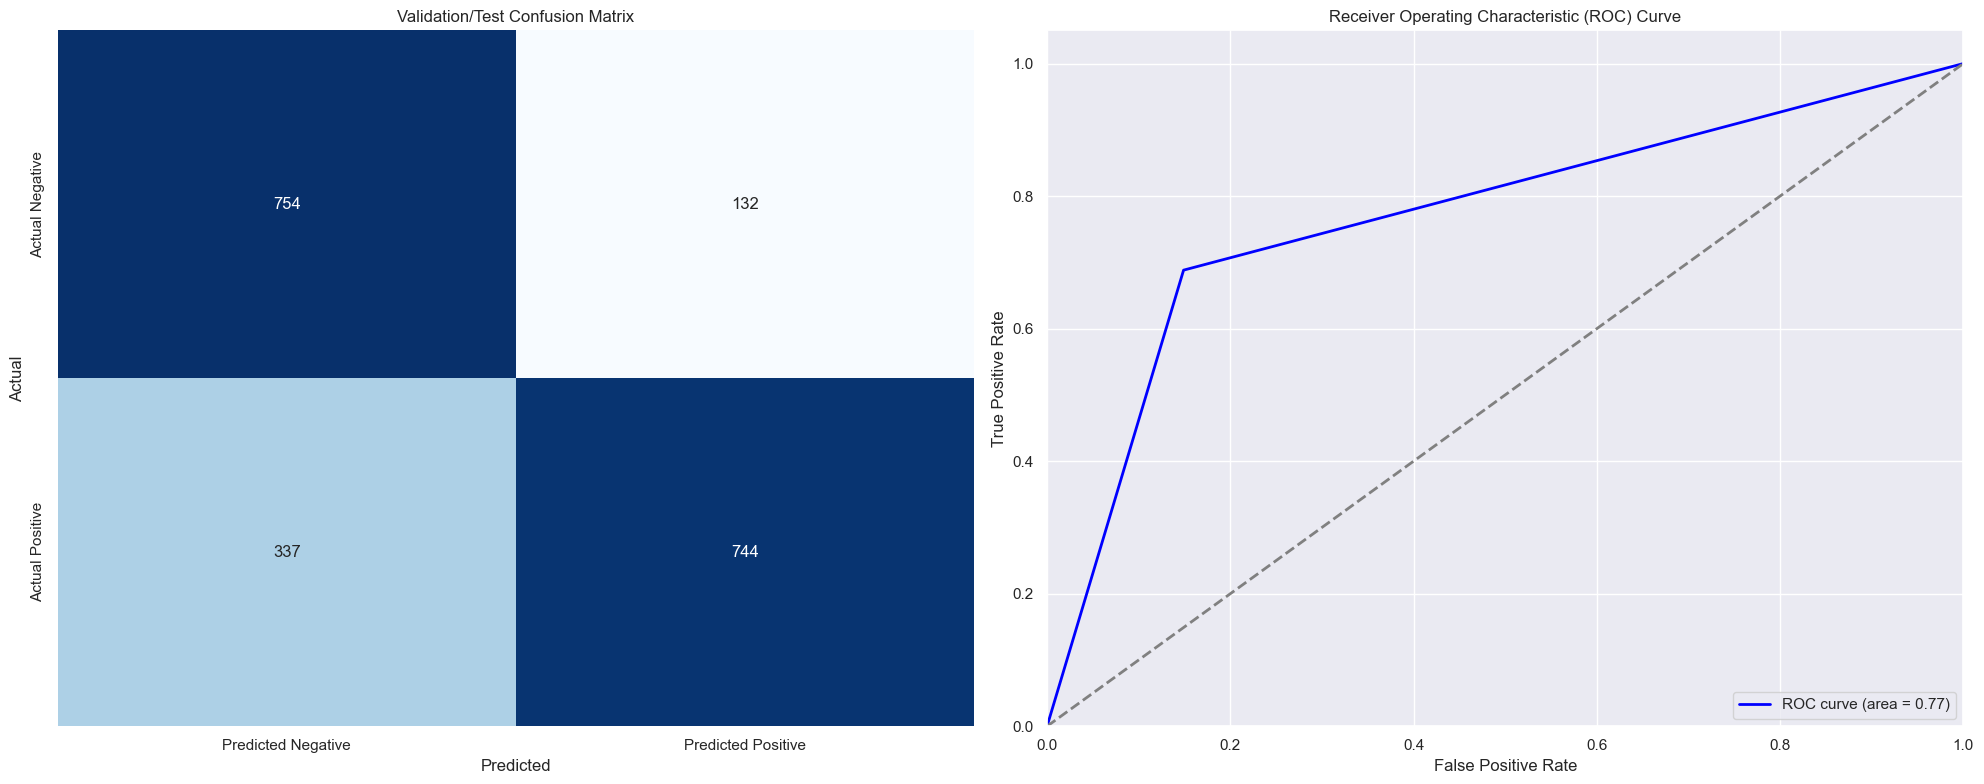

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Training,0.783935,0.721952,0.785948,0.775377,0.862393,0.859520,0.790736
1,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Validation/test,0.758516,0.690102,0.758516,0.751366,0.841986,0.841986,0.766044
2,LogisticRegression,lrc_fit,LogisticRegression - Grid Search - All Features,Training,0.783935,0.720102,0.785516,0.775957,0.864002,0.861777,0.790939
3,LogisticRegression,lrc_fit,LogisticRegression - Grid Search - All Features,Validation/test,0.761566,0.688252,0.760347,0.755869,0.849315,0.851016,0.769634


In [17]:
# initialize variable
Type = 'Validation/Test'

# display
df_classfication = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_test_scale, y_test, Type, metricDF=df_classfication)
df_classfication

### XGBClassifier

#### Explanation of the Gamma Parameter
- In XGBoost, the regularization term that controls the minimum loss reduction required to make a split at a node is known as the "gamma" parameter. This parameter plays a crucial role in the decision-making process of the algorithm during the tree construction phase.
- Definition: The gamma parameter specifies the minimum loss reduction required to make a further partition on a leaf node of the tree. If the reduction in loss from making a split is less than gamma, then that split will not be made.
- Purpose: By setting a higher value for gamma, you can prevent overfitting by making the model more conservative. It effectively controls how complex the model can become by limiting the number of splits. A lower gamma allows more splits and can lead to a more complex model.
- Impact on Model Complexity:
    - High Gamma Value: Results in fewer splits, leading to simpler trees that may underfit the data.
    - Low Gamma Value: Allows more splits, potentially leading to more complex trees that may overfit the training data.

The gamma parameter is essential for controlling the complexity of models built using XGBoost by regulating how much improvement in loss is necessary for splitting nodes. Adjusting this parameter can help balance between bias and variance, thus improving model performance on unseen data.

In [18]:
# import library
from xgboost import XGBClassifier

# calculate the scale_pos_weight to adjust for class imbalance
# helps to counteract the imbalance by giving more weight to the minority class (usually the positive class in binary classification).
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# define the hyperparameter grid to search
parameters = dict(
n_estimators = [50, 100, 200],
max_depth = [3, 5],
learning_rate = [0.05, 0.1, 0.3],
subsample = [0.5, 0.8],
gamma = [0.8, 1, 5, 10] # regularization term that controls the minimum loss reduction required to make a split at a node.
)

# Base Model
xgb_param = {'scale_pos_weight': scale_pos_weight,'random_state': RANDOM_STATE}

# instantiate XGB Classifier
model = XGBClassifier(**xgb_param)

# CV with grid search for Hyper-Parameter tuning
xgb_fit = umf.stratified_grid(model, parameters, X_train_scale, y_train, seed=RANDOM_STATE, nJobs=1, nSplit=5, score='accuracy')

# best model
model = xgb_fit.best_estimator_

CV accuracy: 0.778 +/- 0.010


In [19]:
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=1776, ...)


#### Feature Importance

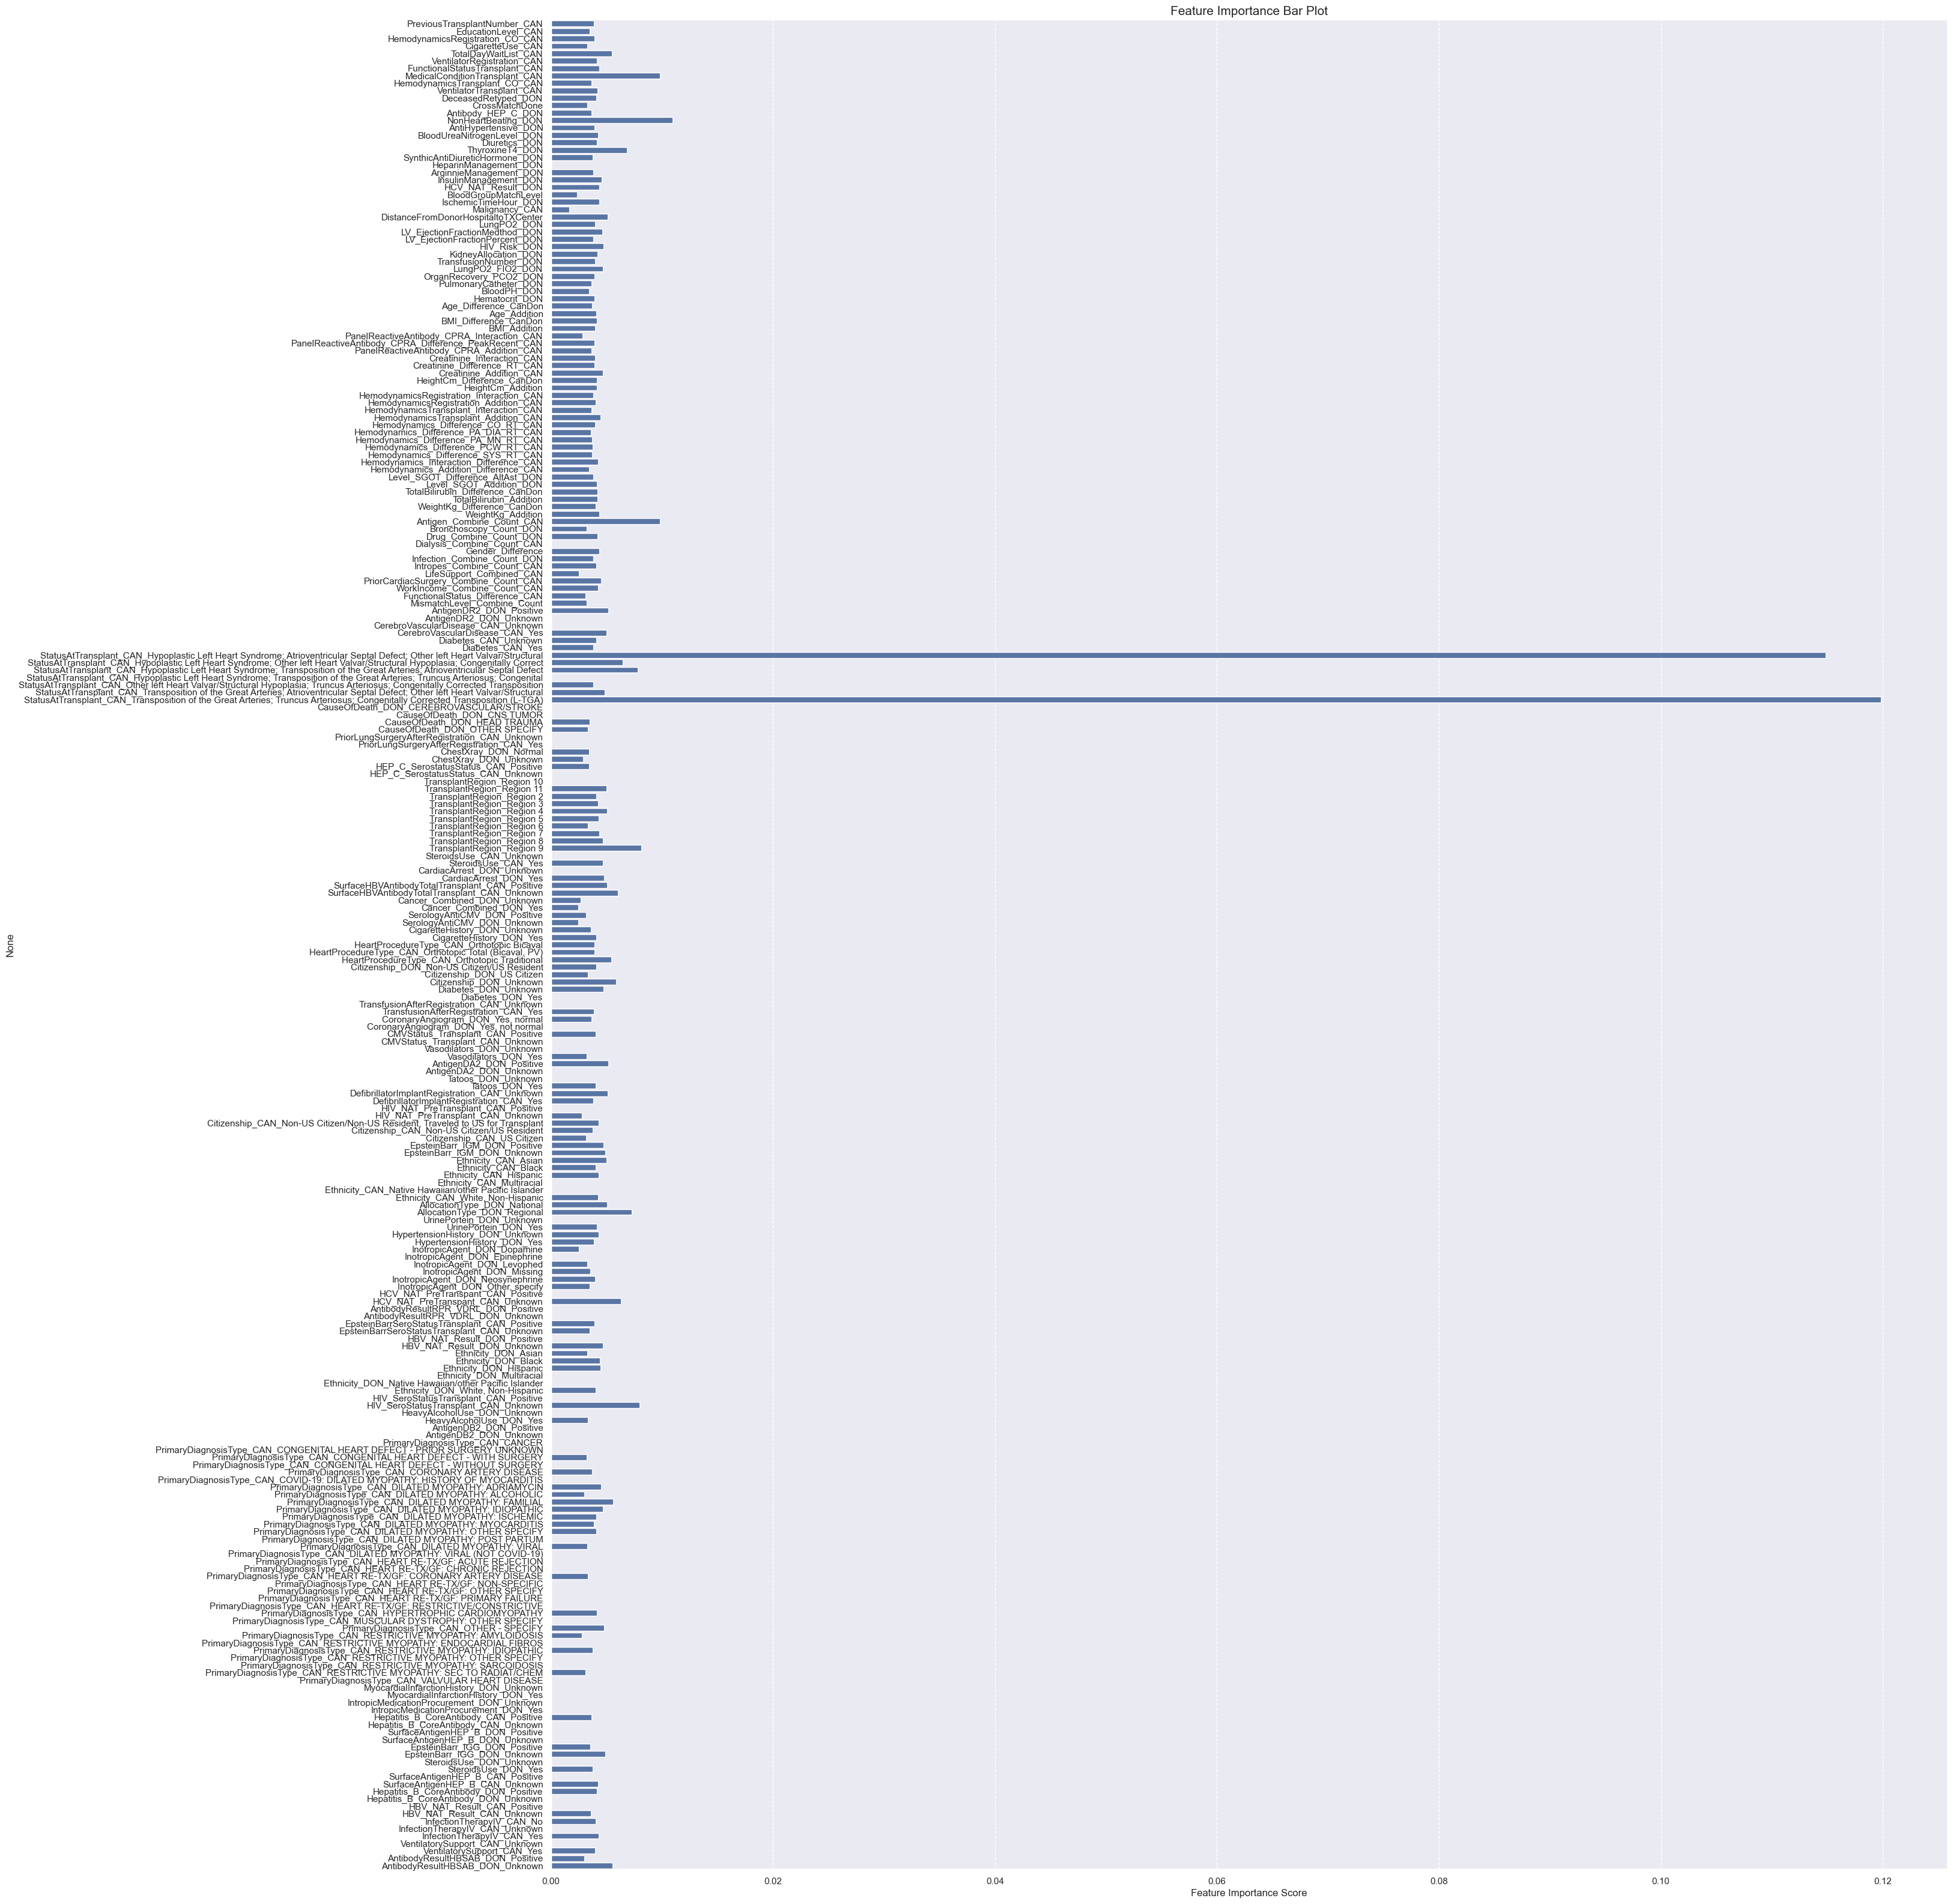

In [20]:
df_xgb = umf.plotFeatureImportance(model, pd.DataFrame(X_train_scale, columns=X_train.columns.to_list()),figsize=(30,40))

In [21]:
df_xgb.sort_values(by='Feature Importance Score', ascending=False).head(10)

,Feature Importance Score
StatusAtTransplant_CAN_Transposition of the Great Arteries; Truncus Arteriosus; Congenitally Corrected Transposition (L-TGA),0.119815
StatusAtTransplant_CAN_Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,0.114838
NonHeartBeating_DON,0.010966
Antigen_Combine_Count_CAN,0.009814
MedicalConditionTransplant_CAN,0.009799
TransplantRegion_Region 9,0.008123
HIV_SeroStatusTransplant_CAN_Unknown,0.007967
StatusAtTransplant_CAN_Hypoplastic Left Heart Syndrome; Transposition of the Great Arteries; Atrioventricular Septal Defect,0.007813
AllocationType_DON_Regional,0.007262
ThyroxineT4_DON,0.006846


#### Metrics

***** Classification Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.91      0.84      3545
        True       0.92      0.79      0.85      4323

    accuracy                           0.85      7868
   macro avg       0.85      0.85      0.85      7868
weighted avg       0.86      0.85      0.85      7868



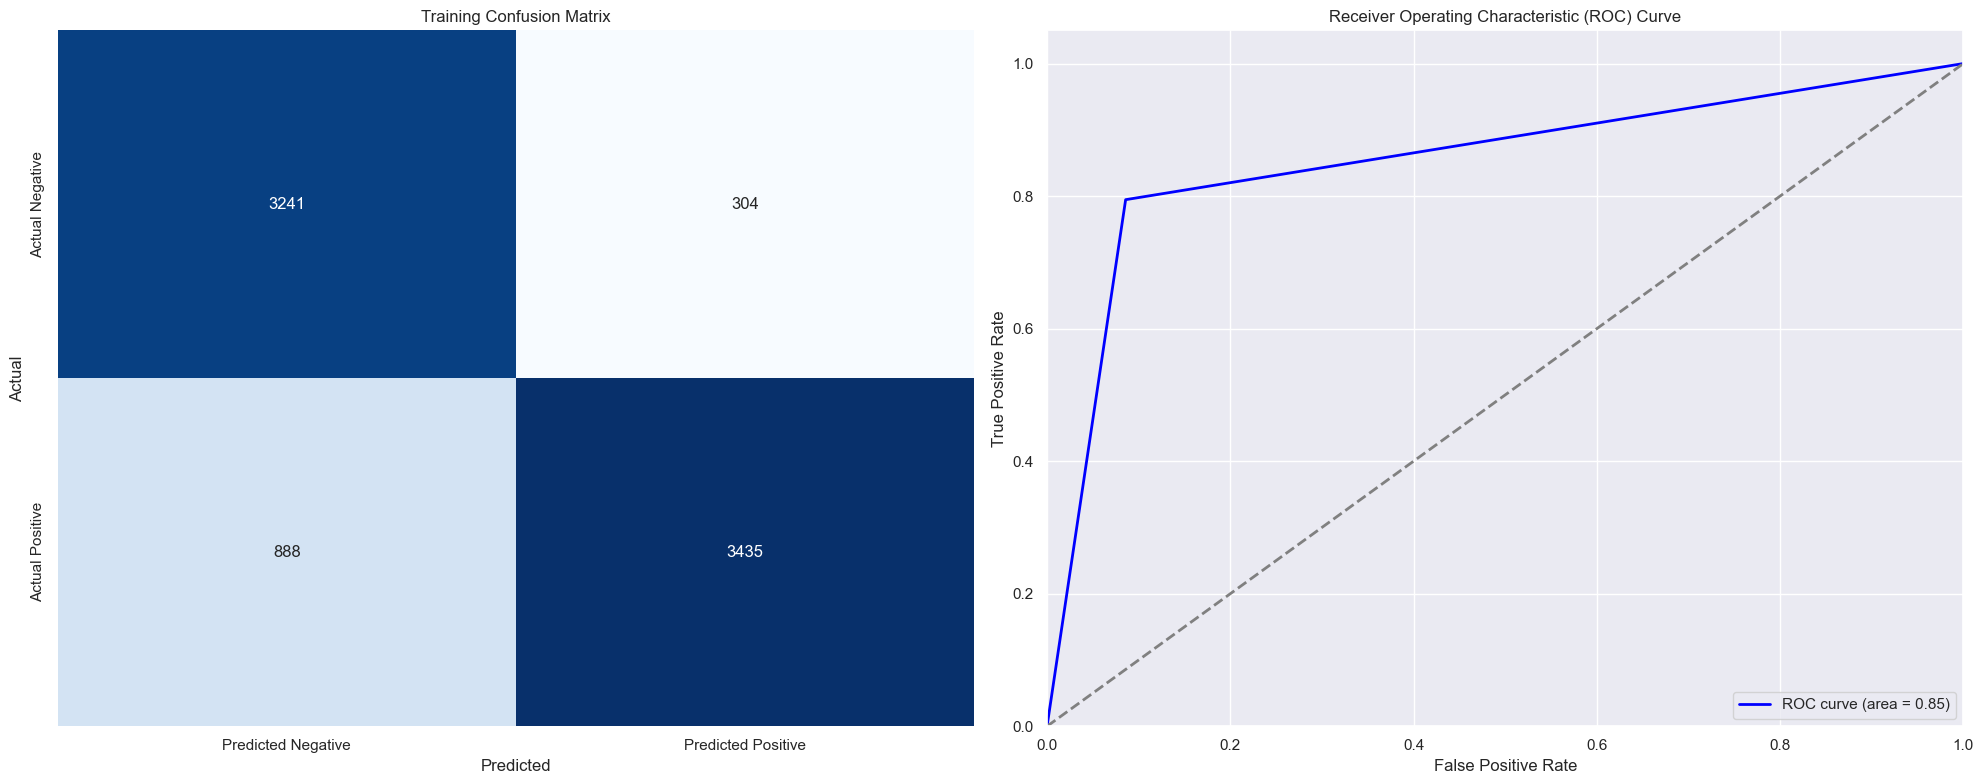

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Training,0.783935,0.721952,0.785948,0.775377,0.862393,0.859520,0.790736
1,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Validation/test,0.758516,0.690102,0.758516,0.751366,0.841986,0.841986,0.766044
2,LogisticRegression,lrc_fit,LogisticRegression - Grid Search - All Features,Training,0.783935,0.720102,0.785516,0.775957,0.864002,0.861777,0.790939
3,LogisticRegression,lrc_fit,LogisticRegression - Grid Search - All Features,Validation/test,0.761566,0.688252,0.760347,0.755869,0.849315,0.851016,0.769634
4,XGBClassifier,xgb_fit,XGBClassifier - Grid Search - All Features,Training,0.848500,0.794587,0.852146,0.842845,0.918695,0.914245,0.854416


In [22]:
# initialize variables
Algorithm = 'XGBClassifier'
Desc = 'XGBClassifier - Grid Search - All Features'
Model = 'xgb_fit'
Type = 'Training'

# display
df_classfication = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_train_scale, y_train, Type, metricDF=df_classfication)
df_classfication

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.87      0.78       886
        True       0.87      0.69      0.77      1081

    accuracy                           0.77      1967
   macro avg       0.79      0.78      0.77      1967
weighted avg       0.79      0.77      0.77      1967



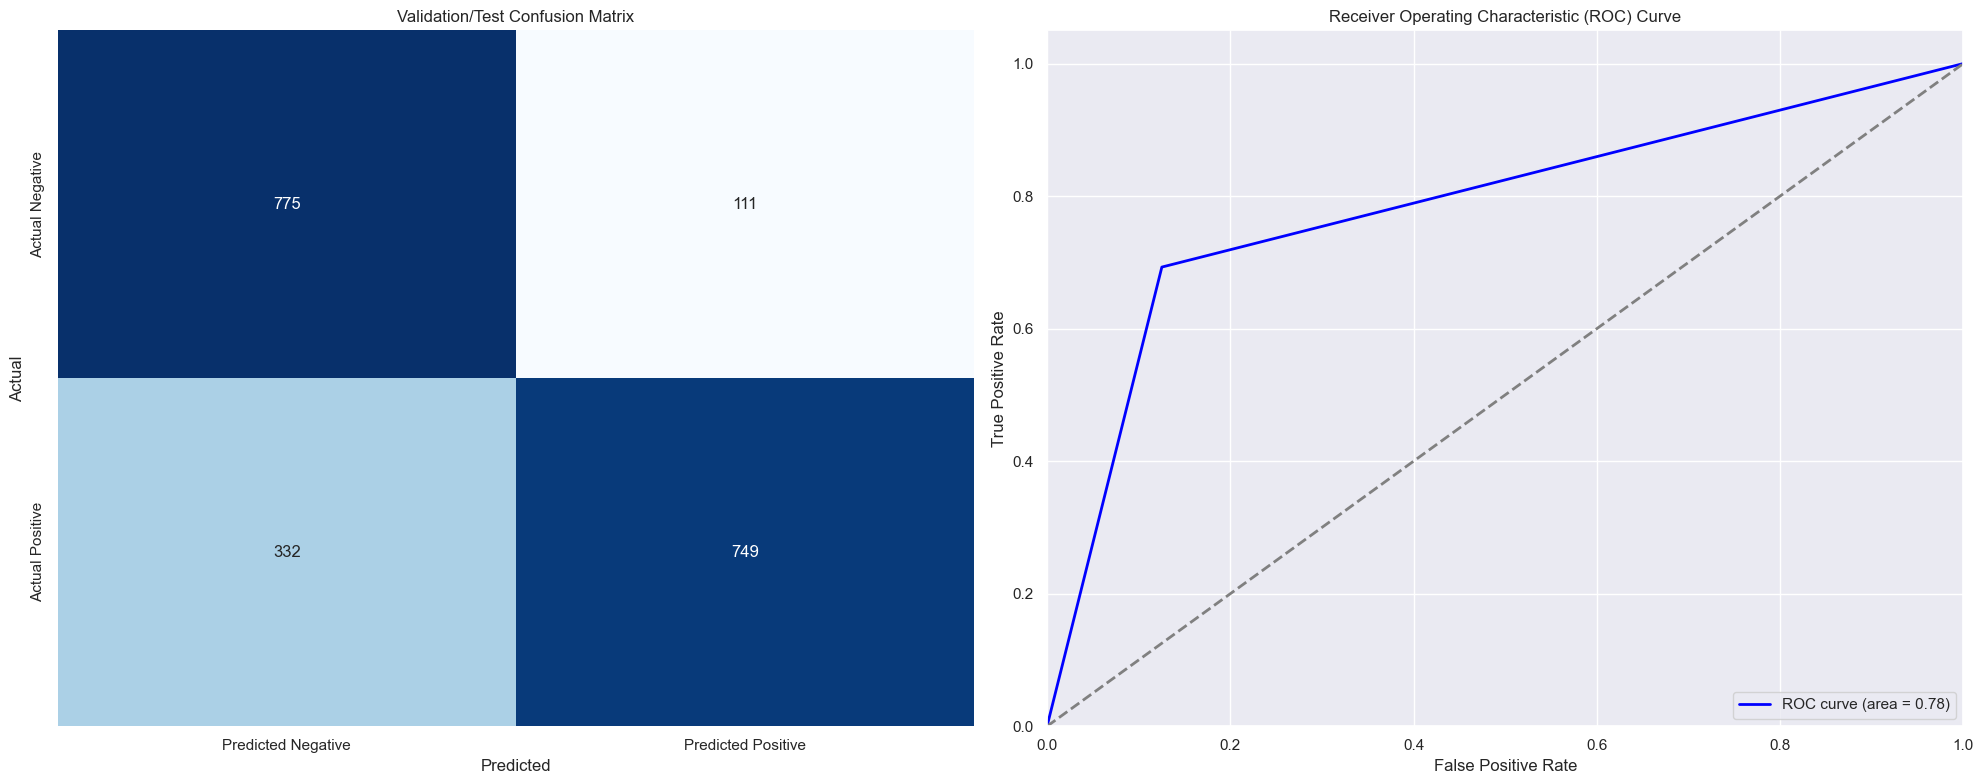

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Training,0.783935,0.721952,0.785948,0.775377,0.862393,0.859520,0.790736
1,RandomForestClassifier,rfc_fit,RandomForestClassifier - Grid Search - All Features,Validation/test,0.758516,0.690102,0.758516,0.751366,0.841986,0.841986,0.766044
2,LogisticRegression,lrc_fit,LogisticRegression - Grid Search - All Features,Training,0.783935,0.720102,0.785516,0.775957,0.864002,0.861777,0.790939
3,LogisticRegression,lrc_fit,LogisticRegression - Grid Search - All Features,Validation/test,0.761566,0.688252,0.760347,0.755869,0.849315,0.851016,0.769634
4,XGBClassifier,xgb_fit,XGBClassifier - Grid Search - All Features,Training,0.848500,0.794587,0.852146,0.842845,0.918695,0.914245,0.854416
5,XGBClassifier,xgb_fit,XGBClassifier - Grid Search - All Features,Validation/test,0.774784,0.692877,0.771767,0.772232,0.870930,0.874718,0.783797


In [23]:
# initialize variable
Type = 'Validation/Test'

# display
df_classfication = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_test_scale, y_test, Type, metricDF=df_classfication)
df_classfication

### SVC

In [ ]:
# import library
from sklearn.svm import SVC

# define the parameter grid for GridSearchCV
parameters = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}

# create a SVC model
model = SVC(random_state=RANDOM_STATE)

# CV with grid search for Hyper-Parameter tuning
svc_fit = umf.stratified_grid(model, parameters, X_train_scale, y_train, seed=RANDOM_STATE, nJobs=1, nSplit=5, score='accuracy')

# best model
model = svc_fit.best_estimator_

In [ ]:
print(model)

#### Metrics

In [ ]:
# initialize variables
Algorithm = 'SVC'
Desc = 'SVC - Grid Search - All Features'
Model = 'svc_fit'
Type = 'Training'

# display
df_classfication = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_train_scale, y_train, Type, metricDF=df_classfication)
df_classfication

In [ ]:
# initialize variable
Type = 'Validation/Test'

# display
df_classfication = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_test_scale, y_test, Type, metricDF=df_classfication)
df_classfication

### User Function

In [ ]:
def LogisticFeatureImportance(model, figsize=(8,10), fontsize=8):
    """
    This function analyzes the importance of features in a logistic regression model by processing its 
    coefficients. It creates a DataFrame with each feature's name, coefficient, effect description, 
    odds ratio, percentage change in odds, and probability, including a horizontal bar plot of feature importance.
    
    Args:
    - model: Trained logistic regression model (e.g., from sklearn).
    - figsize: Tuple defining the figure size for the plot (default: (8, 10)).
    - fontsize: Font size for axis labels and title (default: 8).
    
    Returns:
    - DataFrame: A DataFrame with feature importance details.
    """
    # Check if the model has been fitted and has the coef_ attribute
    if not hasattr(model, 'coef_'):
        raise ValueError("The model must be a fitted logistic regression model.")
    
    # Get feature names and coefficients
    feature_names = model.feature_names_in_
    coefficients = model.coef_
    
    # If it's a multi-class logistic regression, handle each class separately
    if coefficients.ndim > 1:
        coeff_list = []
        for i in range(coefficients.shape[0]):
            class_name = f"Class {i}"
            class_coefficients = coefficients[i]
            coeff_list.append(pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': class_coefficients,
                'Description': ['Decrease in the log-odds of the Positive Class' if x < 0 else 'Increase in the log-odds of the Positive Class' for x in class_coefficients],
                'Odd Ratio': np.exp(class_coefficients),
                'Percentage Change in Odds': (np.exp(class_coefficients) - 1) * 100,
                'Probability': np.exp(class_coefficients) / (1 + np.exp(class_coefficients)),
                'Class': class_name
            }))
        # Concatenate dataframes for all classes
        LRcoeff_df = pd.concat(coeff_list, ignore_index=True)
    else:
        # Single class logistic regression
        LRcoeff_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients[0],
            'Description': ['Decrease in the log-odds of the Positive Class' if x < 0 else 'Increase in the log-odds of the Positive Class' for x in coefficients[0]],
            'Odd Ratio': np.exp(coefficients[0]),
            'Percentage Change in Odds': (np.exp(coefficients[0]) - 1) * 100,
            'Probability': np.exp(coefficients[0]) / (1 + np.exp(coefficients[0])),
        })
    
    # Sort by Coefficient for better visualization
    LRcoeff_df = LRcoeff_df.sort_values(by='Coefficient', ascending=False)
    
    # Reset the index
    LRcoeff_df.reset_index(drop=True, inplace=True)
    
    # Plot feature importance (using Odds Ratio for better interpretability)
    plt.figure(figsize=figsize)
    if 'Class' in LRcoeff_df.columns:
        # Plot for multi-class case
        for class_name in LRcoeff_df['Class'].unique():
            class_df = LRcoeff_df[LRcoeff_df['Class'] == class_name]
            plt.barh(class_df['Feature'], class_df['Odd Ratio'], label=class_name)
    else:
        # Single class logistic regression
        plt.barh(LRcoeff_df['Feature'], LRcoeff_df['Odd Ratio'], color='steelblue')
    
    plt.axvline(1, color='red', linestyle='--', label="Odd Ratio = 1 (No Effect)")
    plt.xlabel("Odds Ratio")
    plt.ylabel("Features")
    plt.title("Feature Importance in Logistic Regression")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return LRcoeff_df
